In [12]:
using Plots
using StatsBase
#using DelimitedFiles
#using CSV
#using DataFrames
FROZEN_STATUS = 2 

2

In [6]:
import Pkg; Pkg.add("StatsBase")

    Updating registry at `C:\Users\ontiv\.julia\registries\General.toml`
   Resolving package versions...
    Updating `C:\Users\ontiv\.julia\environments\v1.8\Project.toml`
  [2913bbd2] + StatsBase v0.33.21
  No Changes to `C:\Users\ontiv\.julia\environments\v1.8\Manifest.toml`


### Functions

In [7]:
mutable struct Walker
    i::Int
    j::Int
    status::Int
end

function move_walker(my_walker::Walker,N::Int)
    if my_walker.status != FROZEN_STATUS
        
        i = my_walker.i
        j = my_walker.j
        directions = [-1,1]
        move_axis = rand(0:1)#the dircetion to move, 0 is x axis, 1 axis, move_direction:
        move_direction = sample(directions)#the dirction to move in -1 or 1

        new_i = i
        new_j = j
        if move_axis == 0 #if move_axis == 0, take a step along the x direction
            new_i=  i+move_direction
        else#if move_axis == 1, take a step along the x direction
            new_j = j+move_direction
        end
        my_walker.i = mod1(new_i,N)
        my_walker.j = mod1(new_j,N)
    end
end

move_walker (generic function with 2 methods)

In [8]:
function plot_ca(grid_history,file_name,fps)
    """
    Takes in a NxNxnum_gens 3d array of grid histories and creates an animation 
    inputs:
        grid_history<matrix>: this is a matrix where every NxN 2d slice is the state of the CA at one time step. The entire 3d matrix stores the history of the ca_gif
        file_name<string>: the resulting animation will be saved as a gif with this file name 
    output:
        ca_fig<gif>: returns the sequence of CA generations as an animated gif. 
    """
    num_gens = size(grid_history)[3]#get the number of frames from the size of the matrix, one frame per generation
    anim = @animate for frame in 1:num_gens#create a heatmap for each frame of the animation
        #heatmap(grid_history[:,:,frame],xaxis = false,yaxis=false,legend = false,ticks=false,background_color_outside = "black",figsize = (15,15))
        heatmap(grid_history[:,:,frame],xaxis = false,yaxis=false,legend = false,ticks=false,background_color_outside = "black")
    end
    ca_gif = gif(anim,file_name,fps=fps)#create a gif from all these heatmaps
    return ca_gif
end

plot_ca (generic function with 1 method)

In [9]:

function get_von_neumann_neighbors(i,j,grid)
    """
    return the  values of the von neuman neighborhood of a given cell at location i,j
    inputs:
        i<int>: the x index of the cell we want to pick 
        j<int>: the y index of the cell we want to pick 
        grid<NxN matrix>: the actual state of the celluar automata, we will pick the grid[i,j] to be the cell we look at
    returns: 
        neighbors<array>: an array of the values of the 4 cells in the von neuman neighborhood of cell i,j
    """
    values = [mod1.(x .+ [-1,0,1], size(grid)[1]) for x in 1:length(grid)]
     values_i = grid[i,values[j]]
     values_j = grid[values[i],j]
     return vcat(values_i,values_j)
end

function move_walker(i,j)
    directions = [-1,1]
    move_axis = rand(0:1)#the dircetion to move, 0 is x axis, 1 axis, move_direction:
    move_direction = sample(directions)#the dirction to move in -1 or 1

    new_i = i
    new_j = j
    if move_axis == 0 #if move_axis == 0, take a step along the x direction
        new_i=  i+move_direction
    else#if move_axis == 1, take a step along the x direction
        new_j = j+move_direction
    end
    return new_i,new_j
end

"""
function DLA_update(i,j,grid)
    grid_size = size(grid)[1]
    if grid[i,j] > 0
        neighborhood = get_von_neumann_neighbors(i,j,grid)
        if FROZEN_STATUS in neighborhood #if a frozen walker is in our neighborhood
            grid[i,j] = FROZEN_STATUS 
        else #if there is no frozen walker, we can pick a cell to move to
            new_i,new_j = move_walker(i,j)#choose a cell to move to
            #impose periodic boundary conditions
            new_i = mod1(new_i,grid_size)
            new_j = mod1(new_j,grid_size)
            grid[new_i,new_j] += 1#add a walker to the new cell
            grid[i,j] -= 1#subtract a walker from the current cell 
        end
        
    end
    return grid
end

function DLA_update_mutual_freeze(i,j,grid)
    """
    #DLA but walkers are frozen if they encounters another walker
    """
    grid_size = size(grid)[1]
    if grid[i,j] > 0
        neighborhood = get_von_neumann_neighbors(i,j,grid)
        if sum(neighborhood) > 2#if a frozen walker is in our neighborhood
            grid[i,j] = FROZEN_STATUS 
        else #if there is no frozen walker, we can pick a cell to move to
            new_i,new_j = move_walker(i,j)#choose a cell to move to
            #impose periodic boundary conditions
            new_i = mod1(new_i,grid_size)
            new_j = mod1(new_j,grid_size)
            grid[new_i,new_j] += 1#add a walker to the new cell
            grid[i,j] -= 1#subtract a walker from the current cell 
        end
        
    end
    return grid
end
"""

function make_grid(walker_pop,N)
    """
    Given a list of walker structs, construct a grid with the location of each walker
    """
    grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
    for walker in walker_pop
        i,j = walker.i,walker.j
        if grid[i,j] != FROZEN_STATUS
            grid[i,j] = walker.status
        end
    end
    return grid
end

make_grid (generic function with 1 method)

Let's start out the with classic random walk, each walker is placed within 10 pixels of the ori

In [121]:
N = 100
R = 50
num_walkers = 500
walkers = []#a list of all the walkers

grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
grid[N÷2,N÷2] = FROZEN_STATUS
num_gens = 100
grid_history_v1 = zeros(Int8,N,N,num_gens)

walker_pop = []

#create a population of walkers
for i in 1:num_walkers 
    di,dj = rand(-R:R,2)
    i = mod1((N÷2)+di,N)
    j = mod1((N÷2)+dj,N)
    push!(walker_pop,Walker(i,j,1))
end

push!(walker_pop,Walker(N÷2,N÷2,FROZEN_STATUS))

for gen in 1:num_gens
    #println("Gen $gen")
    grid_gen_i = make_grid(walker_pop,N)#make a spatial representation of the walker population
    for walker in walker_pop
        i,j = walker.i,walker.j
        neighbors = get_von_neumann_neighbors(i,j,grid_gen_i)
        if FROZEN_STATUS in neighbors
            walker.status = FROZEN_STATUS
        else
            move_walker(walker,N)
        end
    end
    grid_history_v1[:,:,gen] = grid_gen_i#save in the history
end

Gen 1
Gen 2
Gen 3
Gen 4
Gen 5
Gen 6
Gen 7
Gen 8
Gen 9
Gen 10
Gen 11
Gen 12
Gen 13
Gen 14
Gen 15
Gen 16
Gen 17
Gen 18
Gen 19
Gen 20
Gen 21
Gen 22
Gen 23
Gen 24
Gen 25
Gen 26
Gen 27
Gen 28
Gen 29
Gen 30
Gen 31
Gen 32
Gen 33
Gen 34
Gen 35
Gen 36
Gen 37
Gen 38
Gen 39
Gen 40
Gen 41
Gen 42
Gen 43
Gen 44
Gen 45
Gen 46
Gen 47
Gen 48
Gen 49
Gen 50
Gen 51
Gen 52
Gen 53
Gen 54
Gen 55
Gen 56
Gen 57
Gen 58
Gen 59
Gen 60
Gen 61
Gen 62
Gen 63
Gen 64
Gen 65
Gen 66
Gen 67
Gen 68
Gen 69
Gen 70
Gen 71
Gen 72
Gen 73
Gen 74
Gen 75
Gen 76
Gen 77
Gen 78
Gen 79
Gen 80
Gen 81
Gen 82
Gen 83
Gen 84
Gen 85
Gen 86
Gen 87
Gen 88
Gen 89
Gen 90
Gen 91
Gen 92
Gen 93
Gen 94
Gen 95
Gen 96
Gen 97
Gen 98
Gen 99
Gen 100


┌ Info: Saved animation to 
│   fn = /Users/willthompson/Documents/CSDS/MOCS/Project1/MOCS/project2/LDA_test1.gif
└ @ Plots /Users/willthompson/.julia/packages/Plots/4UTBj/src/animation.jl:154


Plots.AnimatedGif("/Users/willthompson/Documents/CSDS/MOCS/Project1/MOCS/project2/LDA_test1.gif")
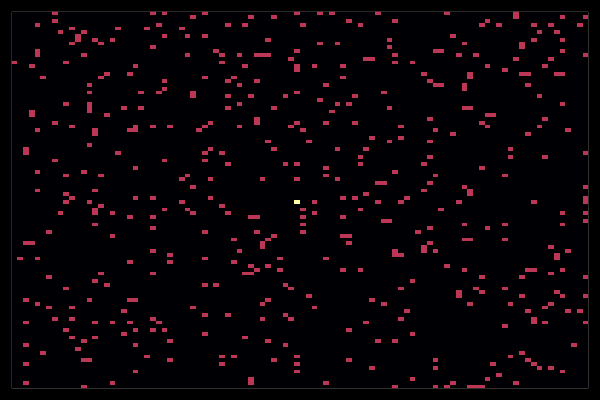

In [122]:
plot_ca(grid_history_v1,"LDA_test1.gif",50)

In [123]:
#write results to a csv
writedlm("grid_history_v1.csv",grid_history_v1,",")

In [18]:
heatmap(grid_history_v1[:,:,10000])

BoundsError: BoundsError: attempt to access 100×100×100 Array{Int8, 3} at index [1:100, 1:100, 10000]

Now Let's run this again with a speedup. When two walkers encounter eachother they freeze. 

In [13]:
N = 64
R = 25 
num_walkers = 400 
walkers = []#a list of all the walkers

grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
grid[N÷2,N÷2] = FROZEN_STATUS
num_gens = 500
grid_history = zeros(Int8,N,N,num_gens)

walker_pop = []

#create a population of walkers
for i in 1:num_walkers 
    di,dj = rand(-R:R,2)
    i = mod1((N÷2)+di,N)
    j = mod1((N÷2)+dj,N)
    push!(walker_pop,Walker(i,j,1))
end

println("Generating Population")
push!(walker_pop,Walker(N÷2,N÷2,FROZEN_STATUS))
println("Finished Generating")

for gen in 1:num_gens
    grid_gen_i = make_grid(walker_pop,N)#make a spatial representation of the walker population
    for walker in walker_pop
        i,j = walker.i,walker.j
        neighbors = get_von_neumann_neighbors(i,j,grid_gen_i)
        if sum(neighbors) > 2
            walker.status = FROZEN_STATUS
        else
            move_walker(walker,N)
        end
    end
    grid_history[:,:,gen] = grid_gen_i#save in the history
end

Generating Population
Finished Generating


┌ Info: Saved animation to 
│   fn = C:\Users\ontiv\anaconda3\Adam's_Scripts\MOCS\Mini project- assn 2\Box counting\LDA_speedup.gif
└ @ Plots C:\Users\ontiv\.julia\packages\Plots\AAjgN\src\animation.jl:139


Plots.AnimatedGif("C:\\Users\\ontiv\\anaconda3\\Adam's_Scripts\\MOCS\\Mini project- assn 2\\Box counting\\LDA_speedup.gif")
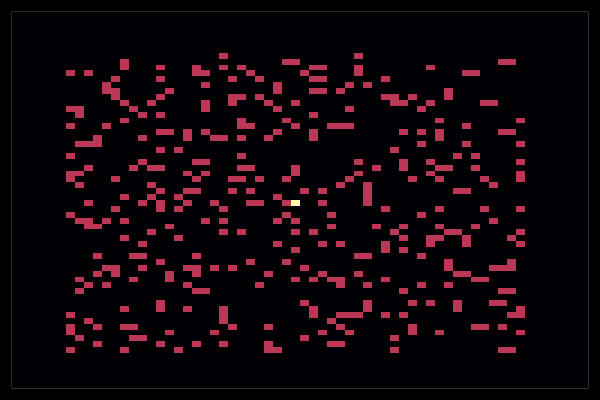

In [14]:
plot_ca(grid_history,"LDA_speedup.gif",50)

# Box Counting

Lets introduce createa a way to measure the Minkowski-Bouligand dimension of our heatmap. 

In [16]:
eval_grid = grid_history[:,:,num_gens]


function MB_dimension(eval_grid)
    #println("here")
    N = size(eval_grid)[1]
    stop_i = log2(N)
    s_vals = [N/2^i for i in 2:stop_i]
    num_occupied_boxes_list = [] 
    total_boxes_list = [] 

    for s in s_vals
        #println("s:$s")
        num_steps = N/s
        num_occupied_boxes = 0
        total_boxes = 0 


        
        for i in 0:(num_steps-1)
            #println("i:$i")
            for j in 0:(num_steps-1)
            #println("\tj:$j")
                #find the range of each slice
                i_start = Int(1+(i*s))
                i_stop = Int((1+i)*s)
                j_start = Int(1+(j*s))
                j_stop = Int((1+j)*s)
                #println("i_start:$i_start,i_stop:$i_stop,j_start:$j_start,j_stop:$j_stop")
                #take an s×s slice of the matrix
                grid_slice = eval_grid[i_start:i_stop,j_start:j_stop]
                #if there are occupied squares, add one to the list of boxes needed to cover our shape
                if sum(grid_slice) > 0
                    println("Here")
                    num_occupied_boxes+=1
                end
                total_boxes+=1
            end
        end
        #push the value of the num occupied boxes to an array 
        push!(num_occupied_boxes_list,num_occupied_boxes)
        push!(total_boxes_list,total_boxes)

        #println("Num Ocuped Boxes:$num_occupied_boxes")
        #println("Num Total Boxes:$total_boxes")
    end

    return reverse(s_vals),reverse(num_occupied_boxes_list)

end
    

function linreg(x,y)
    x_ones = hcat(ones(size(x)[1],1),x)
   (x_ones'x_ones)^(-1)*(x_ones'y)
end

linreg (generic function with 1 method)

Lets Measure the MB Dimesion of a regular polygon like a square

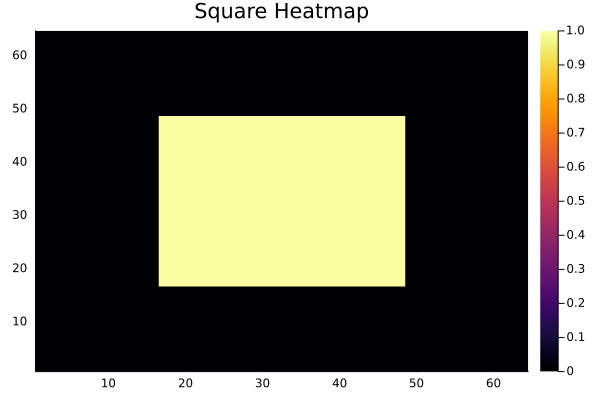

In [22]:
N = 64
square_grid = zeros(N,N)
square_grid[Int((N/4)+1):Int(3N/4),Int((N/4)+1):Int(3N/4)] .= 1
#square_grid[Int((N/4)):Int(3N/4),Int((N/4)):Int(3N/4)] .= 1
heatmap(square_grid,title = "Square Heatmap")

In [23]:
square_s_vals,square_num_occupied_boxes_list = MB_dimension(square_grid)
#plot(square_s_vals,square_num_occupied_boxes_list,xlabel = "s",ylabel ="Num Boxes to Cover",

here
s:16.0
i:0.0
	j:0.0
i_start:1,i_stop:16,j_start:1,j_stop:16
	j:1.0
i_start:1,i_stop:16,j_start:17,j_stop:32
	j:2.0
i_start:1,i_stop:16,j_start:33,j_stop:48
	j:3.0
i_start:1,i_stop:16,j_start:49,j_stop:64
i:1.0
	j:0.0
i_start:17,i_stop:32,j_start:1,j_stop:16
	j:1.0
i_start:17,i_stop:32,j_start:17,j_stop:32
Here
	j:2.0
i_start:17,i_stop:32,j_start:33,j_stop:48
Here
	j:3.0
i_start:17,i_stop:32,j_start:49,j_stop:64
i:2.0
	j:0.0
i_start:33,i_stop:48,j_start:1,j_stop:16
	j:1.0
i_start:33,i_stop:48,j_start:17,j_stop:32
Here
	j:2.0
i_start:33,i_stop:48,j_start:33,j_stop:48
Here
	j:3.0
i_start:33,i_stop:48,j_start:49,j_stop:64
i:3.0
	j:0.0
i_start:49,i_stop:64,j_start:1,j_stop:16
	j:1.0
i_start:49,i_stop:64,j_start:17,j_stop:32
	j:2.0
i_start:49,i_stop:64,j_start:33,j_stop:48
	j:3.0
i_start:49,i_stop:64,j_start:49,j_stop:64
Num Ocuped Boxes:4
Num Total Boxes:16
s:8.0
i:0.0
	j:0.0
i_start:1,i_stop:8,j_start:1,j_stop:8
	j:1.0
i_start:1,i_stop:8,j_start:9,j_stop:16
	j:2.0
i_start:1,i_stop:8,j

In [24]:


log_square_num_occupied_boxes = log2.(square_num_occupied_boxes_list)
log_square_s_vals = log2.((square_s_vals))
plot(log_square_num_occupied_boxes,log_square_s_vals)
linreg(log_square_s_vals,log_square_num_occupied_boxes)

2-element Vector{Float64}:
 10.000000000000002
 -2.0

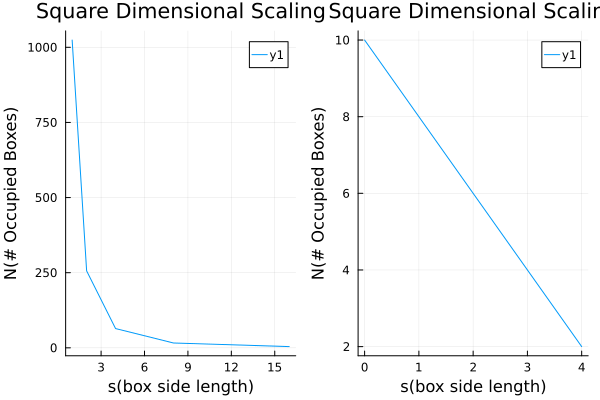

In [25]:
lin_plot = plot(square_s_vals,square_num_occupied_boxes_list,ylabel = "N(# Occupied Boxes)",xlabel = "s(box side length)",title = "Square Dimensional Scaling")
log_plot = plot(log_square_s_vals,log_square_num_occupied_boxes,ylabel = "N(# Occupied Boxes)",xlabel = "s(box side length)",title = "Square Dimensional Scaling")
plot(lin_plot,log_plot,layout = 2)

Now lets run on the sped-up DLA

In [28]:
speed_grid = grid_history[:,:,num_gens]
speed_s_vals,speed_num_occupied_boxes_list = MB_dimension(speed_grid)


log_speed_num_occupied_boxes = log2.(speed_num_occupied_boxes_list)
log_speed_s_vals = log2.((speed_s_vals))
plot(log_speed_num_occupied_boxes,log_speed_s_vals)
linreg(log_speed_s_vals,log_speed_num_occupied_boxes)

here
s:16.0
i:0.0
	j:0.0
i_start:1,i_stop:16,j_start:1,j_stop:16
Here
	j:1.0
i_start:1,i_stop:16,j_start:17,j_stop:32
Here
	j:2.0
i_start:1,i_stop:16,j_start:33,j_stop:48
Here
	j:3.0
i_start:1,i_stop:16,j_start:49,j_stop:64
Here
i:1.0
	j:0.0
i_start:17,i_stop:32,j_start:1,j_stop:16
Here
	j:1.0
i_start:17,i_stop:32,j_start:17,j_stop:32
Here
	j:2.0
i_start:17,i_stop:32,j_start:33,j_stop:48
Here
	j:3.0
i_start:17,i_stop:32,j_start:49,j_stop:64
Here
i:2.0
	j:0.0
i_start:33,i_stop:48,j_start:1,j_stop:16
Here
	j:1.0
i_start:33,i_stop:48,j_start:17,j_stop:32
Here
	j:2.0
i_start:33,i_stop:48,j_start:33,j_stop:48
Here
	j:3.0
i_start:33,i_stop:48,j_start:49,j_stop:64
Here
i:3.0
	j:0.0
i_start:49,i_stop:64,j_start:1,j_stop:16
Here
	j:1.0
i_start:49,i_stop:64,j_start:17,j_stop:32
Here
	j:2.0
i_start:49,i_stop:64,j_start:33,j_stop:48
Here
	j:3.0
i_start:49,i_stop:64,j_start:49,j_stop:64
Here
Num Ocuped Boxes:16
Num Total Boxes:16
s:8.0
i:0.0
	j:0.0
i_start:1,i_stop:8,j_start:1,j_stop:8
	j:1.0
i_sta

2-element Vector{Float64}:
  8.937388056059138
 -1.1459547686622757

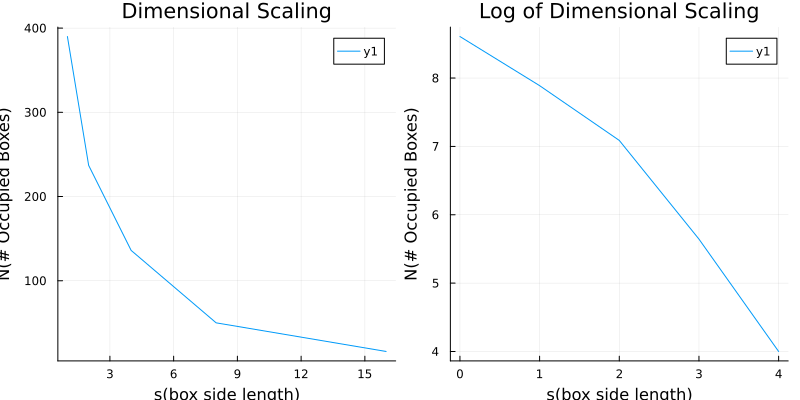

In [38]:
lin_plot = plot(speed_s_vals,speed_num_occupied_boxes_list,ylabel = "N(# Occupied Boxes)",xlabel = "s(box side length)",title = "Dimensional Scaling")
log_plot = plot(log_speed_s_vals,log_speed_num_occupied_boxes,ylabel = "N(# Occupied Boxes)",xlabel = "s(box side length)",title = "Log of Dimensional Scaling")
plot(lin_plot,log_plot,layout = 2)
plot!(size = (800, 400))